# IMPORTS AND READ CSV

In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [2]:
df_time_series = pd.read_csv('datasets/historical_demand_sum.csv', index_col='time_index')
df_time_series.index = pd.to_datetime(df_time_series.index)

df_time_series.head()

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06


<AxesSubplot: xlabel='time_index'>

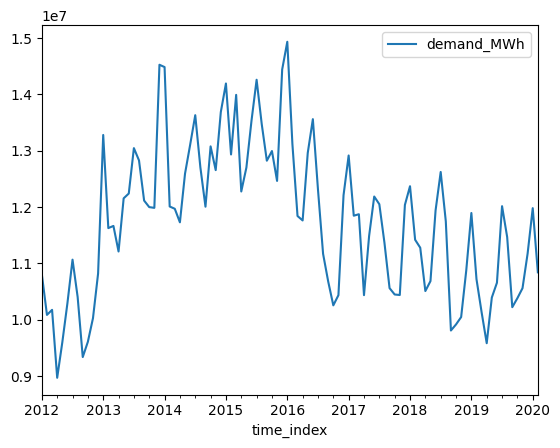

In [3]:
df_time_series.plot()

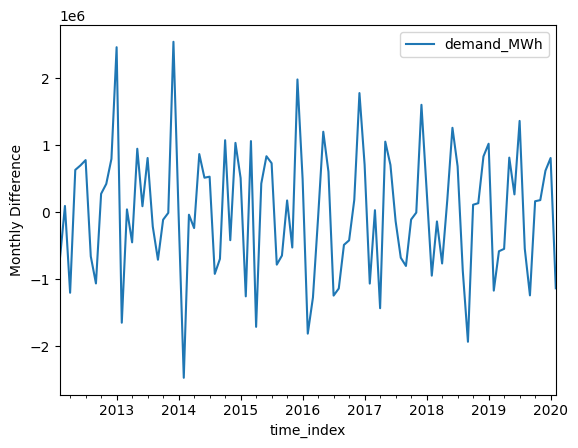

In [4]:
# Need to difference
df_time_series_diff_first = df_time_series.diff().dropna()
ax = df_time_series_diff_first.plot()
ax.set_ylabel("Monthly Difference")
plt.show()

In [5]:
utils.is_stationary(df_time_series_diff_first)

False

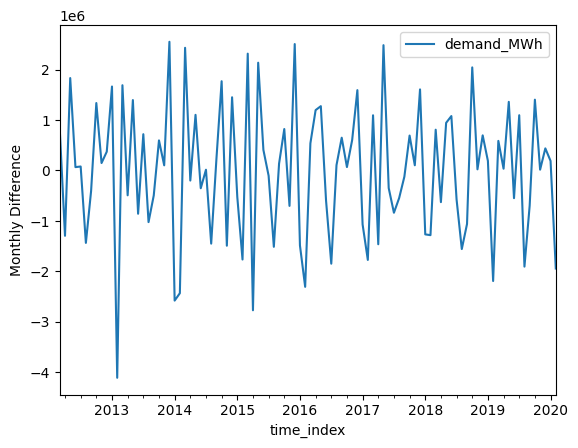

In [6]:
# Differenciate again
df_time_series_diff_second = df_time_series_diff_first.diff().dropna()
ax = df_time_series_diff_second.plot()
ax.set_ylabel("Monthly Difference")
plt.show()

In [7]:
utils.is_stationary(df_time_series_diff_second)

True

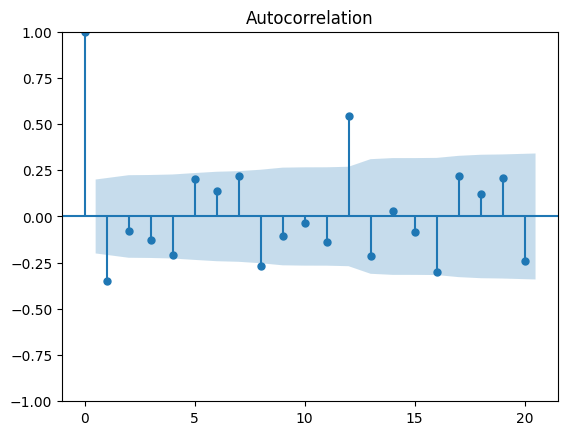

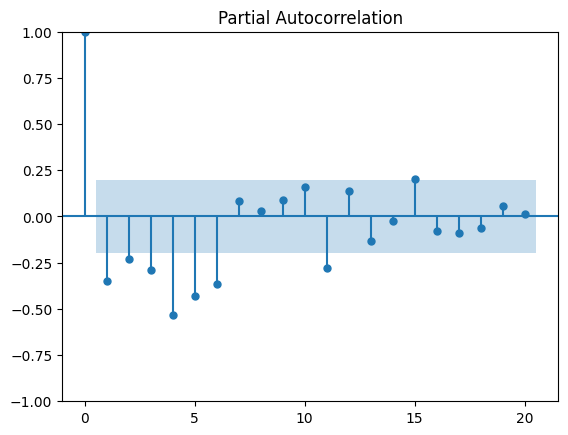

In [8]:
plot_acf(df_time_series_diff_second, lags=20)
plot_pacf(df_time_series_diff_second, lags=20, method="ywm")
plt.show()

/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


0.6999744060057267


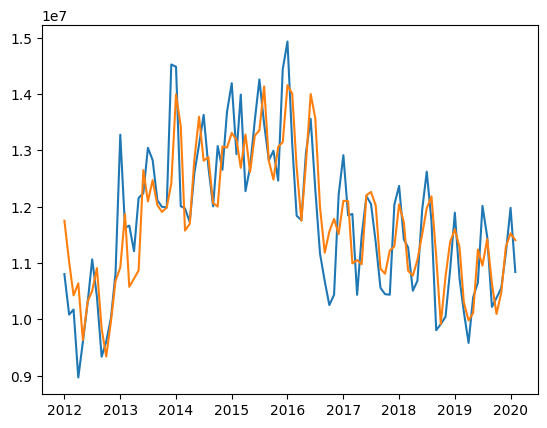

In [9]:
# Forecast the first ARMA(1,1) model
mod = ARIMA(df_time_series, order=(5,0,1))
res = mod.fit()
orig_data = df_time_series
pred = res.predict()
print(r2_score(orig_data, pred))
plt.plot(orig_data)
plt.plot(pred)
plt.show()

# RESIDUALS

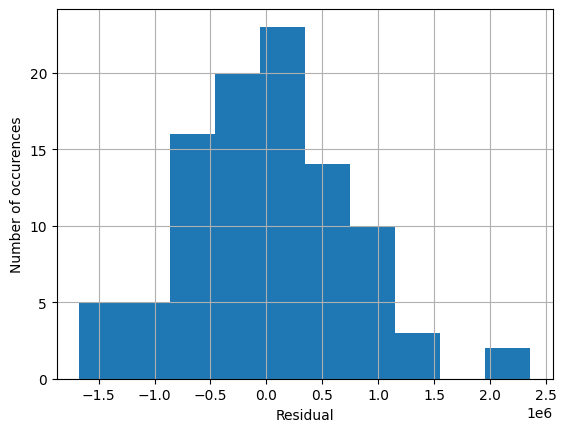

In [10]:
ax = pd.Series(res.resid).hist()
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Residual')
plt.show()

In [11]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             demand_MWh   No. Observations:                   98
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -1461.492
Date:                Mon, 24 Oct 2022   AIC                           2938.984
Time:                        16:57:52   BIC                           2959.664
Sample:                    01-01-2012   HQIC                          2947.349
                         - 02-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.175e+07   1.41e-08   8.33e+14      0.000    1.18e+07    1.18e+07
ar.L1          0.7675      0.206      3.732      0.000       0.364       1.171
ar.L2         -0.1774      0.187     -0.947      0.343      -0.544       0.190
ar.L3         -0.0669      0.140     -0.478      0.632      -0.341       0.207
ar.L4         -0.0149      0.133     -0.112      0.911      -0.276       0.246
ar.L5          0.4325      0.136      3.188      0.001       0.167       0.698
ma.L1         -0.1368      0.241     -0.568      0.570      -0.608       0.335
sigma2      5.159e+11   6.21e-13   8.31e+23      0.000    5.16e+11    5.16e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.77
Prob(Q):                              0.98   Prob(JB):                         0.06
Heteroskedasticity (H):               0.40   Skew:                             0.50
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.59e+39. Standard errors may be unstable.
"""

# PMDARIMA

In [12]:
df_time_series.shape[0]

98

In [18]:
train, test = train_test_split(df_time_series[['demand_MWh']], train_size=df_time_series[['demand_MWh']].size-10)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=6)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

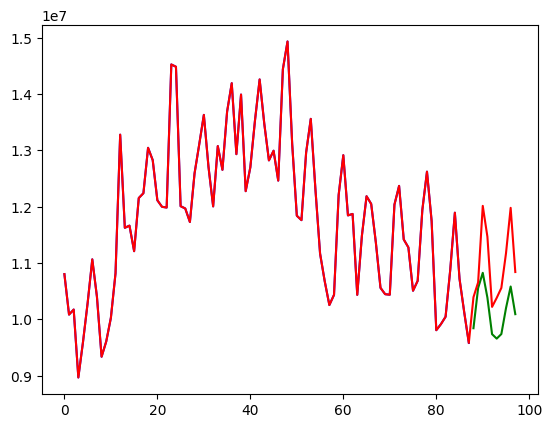

In [23]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(df_time_series.size)
plt.plot(x[:(df_time_series.size-10)], train, c='blue')
plt.plot(x[(df_time_series.size-10):], forecasts, c='green')
plt.plot(x, df_time_series, c='red')
plt.show()

In [19]:
model

ARIMA(order=(4, 1, 0), scoring_args={}, seasonal_order=(2, 0, 1, 6),
      suppress_warnings=True, with_intercept=False)

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   88
Model:             SARIMAX(4, 1, 0)x(2, 0, [1], 6)   Log Likelihood               -1295.990
Date:                             Mon, 24 Oct 2022   AIC                           2607.980
Time:                                     17:14:10   BIC                           2627.708
Sample:                                 01-01-2012   HQIC                          2615.924
                                      - 04-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0985      0.100     -0.982      0.326      -0.295       0.098
ar.L2         -0.1088      0.057     -1.898      0.058      -0.221       0.004
ar.L3         -0.1713      0.076     -2.262      0.024      -0.320      -0.023
ar.L4         -0.0427      0.057     -0.754      0.451      -0.154       0.068
ar.S.L6        0.3563      0.201      1.773      0.076      -0.037       0.750
ar.S.L12       0.2930      0.088      3.319      0.001       0.120       0.466
ma.S.L6       -0.3535      0.218     -1.618      0.106      -0.782       0.075
sigma2      5.578e+11    1.6e-13   3.49e+24      0.000    5.58e+11    5.58e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.84   Prob(JB):                         0.70
Heteroskedasticity (H):               0.56   Skew:                            -0.00
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.21e+40. Standard errors may be unstable.
"""

In [21]:
pm.show_versions()


System:
    python: 3.8.10 (default, Mar 15 2022, 12:22:08)  [GCC 9.4.0]
executable: /home/tomas/codes/electric_energy_demand_argentina/env/bin/python
   machine: Linux-5.10.102.1-microsoft-standard-WSL2-x86_64-with-glibc2.29

Python dependencies:
        pip: 20.0.2
 setuptools: 44.0.0
    sklearn: 1.1.2
statsmodels: 0.13.2
      numpy: 1.23.3
      scipy: 1.9.2
     Cython: 0.29.32
     pandas: 1.5.0
     joblib: 1.2.0
   pmdarima: 2.0.1


In [22]:
type(df_time_series.index.month)

pandas.core.indexes.numeric.Int64Index

In [48]:
def four_months_period(data):
    array_four_months_period = np.array([])
    for i in data.month:
        if i <= 4:
            array_four_months_period = np.append(array_four_months_period, [1])
        if i > 4 and i <= 8:
            array_four_months_period = np.append(array_four_months_period, [2])
        if i > 8 and i <= 12:
            array_four_months_period = np.append(array_four_months_period, [3])
    return array_four_months_period

In [49]:
def six_months_period(data):
    array_six_months_period = np.array([])
    for i in data.month:
        if i <= 6:
            array_six_months_period = np.append(array_six_months_period, [1])
        if i > 6 and i <= 12:
            array_six_months_period = np.append(array_six_months_period, [2])
    return array_six_months_period

In [50]:
df_time_series['four_months_period'] = (four_months_period(df_time_series.index))
df_time_series['six_months_period'] = (six_months_period(df_time_series.index))

<AxesSubplot: title={'center': 'Seasonal Plot (year/month)'}, xlabel='month', ylabel='demand_MWh'>

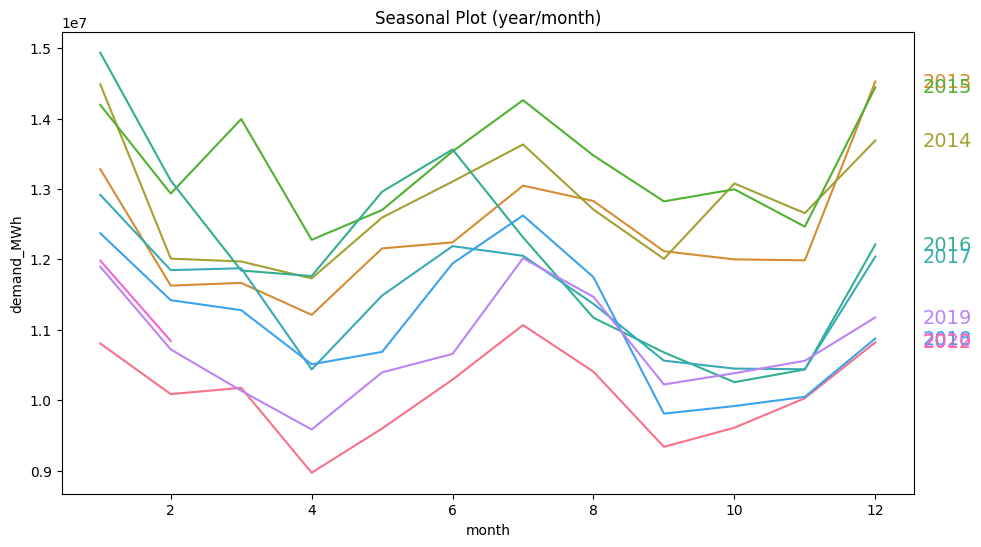

In [53]:
# days within a week
# X["day"] = X.index.dayofweek  # the x-axis (freq)
# X["week"] = X.index.week  # the seasonal period (period)
df_time_series["year"] = df_time_series.index.year  # the x-axis (freq)
df_time_series["month"] = df_time_series.index.month  # the seasonal period (period)
df_time_series["quarter"] = df_time_series.index.quarter  # the seasonal period (period)

# days within a year

fig, ax = plt.subplots(figsize=(11, 6))
utils.seasonal_plot(df_time_series, y="demand_MWh", period="year", freq="month", ax=ax)

/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


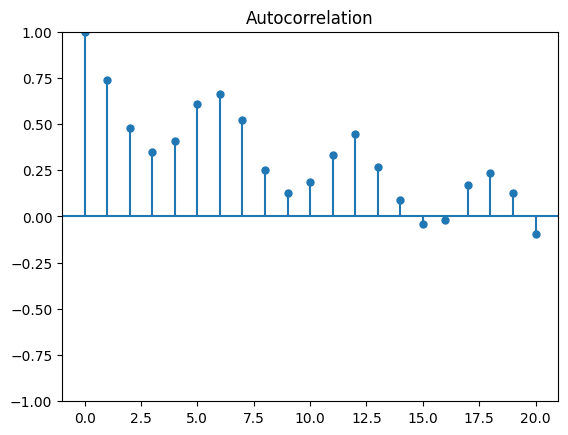

In [22]:
pm.plot_acf(df_time_series['demand_MWh'])

<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

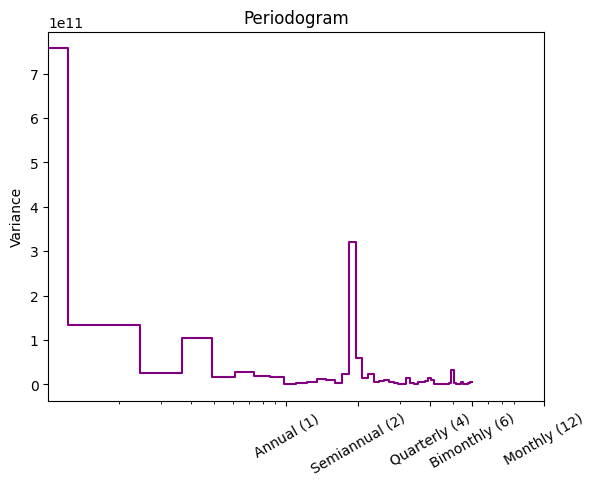

In [23]:
utils.plot_periodogram(df_time_series['demand_MWh'])

In [43]:
sd = seasonal_decompose(df_time_series['demand_MWh'], period=6)
df_time_series['observed'] = sd.observed
df_time_series['residual'] = sd.resid
df_time_series['seasonal'] = sd.seasonal
df_time_series['trend'] = sd.trend

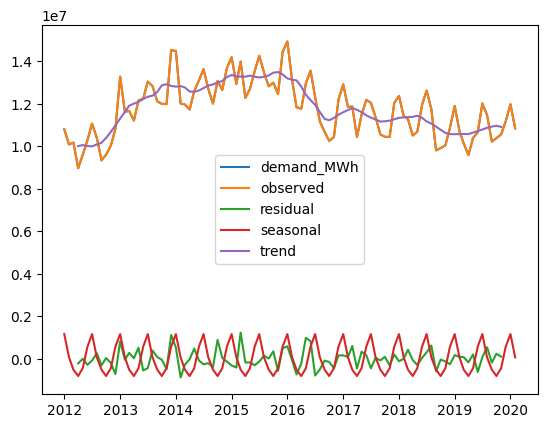

In [44]:
plt.plot(df_time_series['demand_MWh'])
plt.plot(df_time_series['observed'])
plt.plot(df_time_series['residual'])
plt.plot(df_time_series['seasonal'])
plt.plot(df_time_series['trend'])
plt.legend(['demand_MWh', 'observed', 'residual', 'seasonal', 'trend'])
plt.show()

In [49]:
sd2 = pm.arima.decompose(df_time_series['demand_MWh'], type_='additive', m=12)

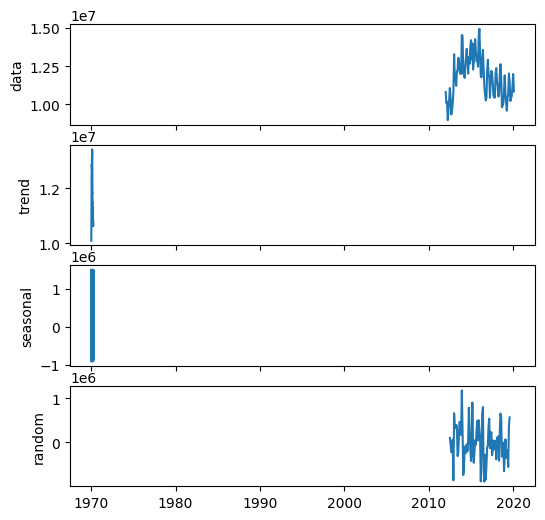

In [50]:
pm.utils.visualization.decomposed_plot(sd2, figure_kwargs={'figsize': (6, 6)})

In [52]:
a,b,c,d = sd2

In [60]:
sd2.

AttributeError: 'decomposed' object has no attribute 'dict'